In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/a-large-scale-fish-dataset/Segmentation_example_script.m
/kaggle/input/a-large-scale-fish-dataset/README.txt
/kaggle/input/a-large-scale-fish-dataset/license.txt
/kaggle/input/a-large-scale-fish-dataset/NA_Fish_Dataset/Black Sea Sprat/00033.png
/kaggle/input/a-large-scale-fish-dataset/NA_Fish_Dataset/Black Sea Sprat/00004.png
/kaggle/input/a-large-scale-fish-dataset/NA_Fish_Dataset/Black Sea Sprat/00023.png
/kaggle/input/a-large-scale-fish-dataset/NA_Fish_Dataset/Black Sea Sprat/00041.png
/kaggle/input/a-large-scale-fish-dataset/NA_Fish_Dataset/Black Sea Sprat/00024.png
/kaggle/input/a-large-scale-fish-dataset/NA_Fish_Dataset/Black Sea Sprat/00035.png
/kaggle/input/a-large-scale-fish-dataset/NA_Fish_Dataset/Black Sea Sprat/00045.png
/kaggle/input/a-large-scale-fish-dataset/NA_Fish_Dataset/Black Sea Sprat/00038.png
/kaggle/input/a-large-scale-fish-dataset/NA_Fish_Dataset/Black Sea Sprat/00025.png
/kaggle/input/a-large-scale-fish-dataset/NA_Fish_Dataset/Black Sea Sprat/0000

In [2]:
import warnings 

# Tüm uyarıları görmezden gel
warnings.filterwarnings("ignore")
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
from kerastuner.tuners import RandomSearch


### 1. Gerekli Kütüphanelerin İçe Aktarılması ve Uyarıların Gizlenmesi

Bu bölümde, projemizde kullanacağımız tüm gerekli kütüphaneleri içe aktarıyoruz. warnings kütüphanesi, gereksiz uyarıları gizlemek için kullanılıyor. os, numpy, pandas, matplotlib ve seaborn, veri işleme ve görselleştirme için gerekli kütüphaneler. TensorFlow ve Keras, yapay sinir ağı modelimizi oluşturmak için kullanıyoruz. Ayrıca, ImageDataGenerator, görüntü verilerimizi artırmak ve eğitmek için kullanılırken, confusion_matrix ve classification_report sınıflandırma sonuçlarımızı değerlendirmek için kullanılacak. Son olarak, kerastuner kütüphanesi, hiperparametre optimizasyonu yapmak için gerekli.

In [3]:
fish_dir = '/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset'
img_height = 128
img_width = 128
batch_size = 16


### 2. Sabitlerin Tanımlanması

Bu bölümde, projemiz için bazı sabitleri tanımlıyoruz. fish_dir, veri setimizin bulunduğu dizini belirtirken, img_height ve img_width, resimlerimizin boyutlarını ayarlamak için kullanılıyor. batch_size ise modelin her eğitim adımında kullanacağı örnek sayısını belirliyor. Bu parametreler, modelimizin eğitim sürecini optimize etmek için önemli.

In [4]:
label = []
path = []

for dir_name, _, filenames in os.walk(fish_dir):
    for filename in filenames:
        if os.path.splitext(filename)[-1] == '.png':
            if dir_name.split()[-1] != 'GT':
                label.append(os.path.split(dir_name)[-1])
                path.append(os.path.join(dir_name, filename))

data = pd.DataFrame(columns=['path', 'label'])
data['path'] = path
data['label'] = label

print(data.head())


                                                path            label
0  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
1  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
2  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
3  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
4  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel


### 3. Veri Çerçevesinin Oluşturulması

Bu kısımda, balık veri setimiz için etiketler ve dosya yolları içeren iki liste oluşturuyoruz. os.walk kullanarak, veri seti klasöründeki tüm dosyaları dolaşıyoruz. Her dosyanın uzantısı .png ise ve klasörü "GT" değilse, dosyanın yolunu ve etiketini topluyoruz. Bu bilgilerle bir Pandas DataFrame oluşturuyoruz. Son olarak, data.head() ile DataFrame'imizin ilk birkaç satırını görüntüleyerek verimizin yapısını kontrol ediyoruz.

label
Hourse Mackerel       1000
Black Sea Sprat       1000
Sea Bass              1000
Red Mullet            1000
Trout                 1000
Striped Red Mullet    1000
Shrimp                1000
Gilt-Head Bream       1000
Red Sea Bream         1000
Name: count, dtype: int64


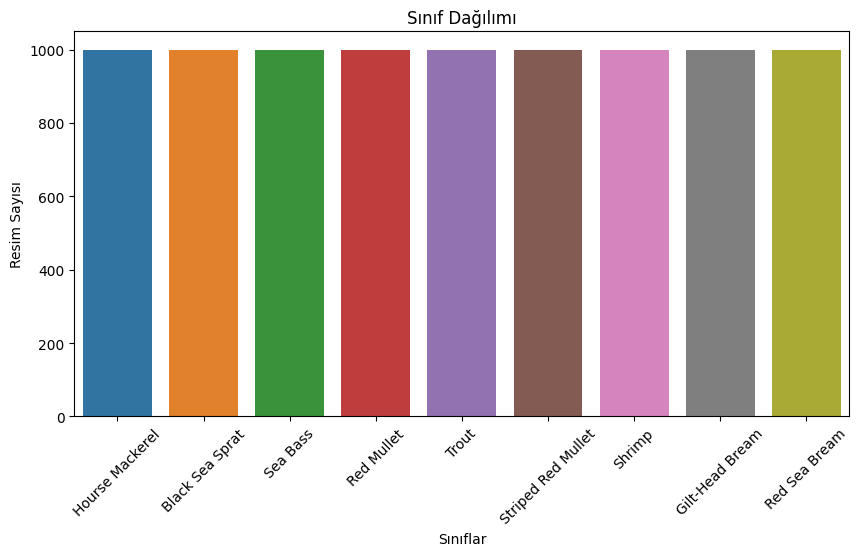

In [5]:
class_counts = data['label'].value_counts()
print(class_counts)

plt.figure(figsize=(10, 5))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title('Sınıf Dağılımı')
plt.xlabel('Sınıflar')
plt.ylabel('Resim Sayısı')
plt.xticks(rotation=45)
plt.show()


### 4. Sınıf Dağılımının Görselleştirilmesi

Bu bölümde, her sınıftan kaç adet resim olduğunu sayıyoruz ve bu verileri bir çubuk grafikte görselleştiriyoruz. value_counts() ile her bir sınıfın sayısını alıyoruz ve seaborn kütüphanesi ile görseli oluşturuyoruz. Bu görselleştirme, veri setimizin dengesini ve sınıf dağılımını anlamak için önemli.

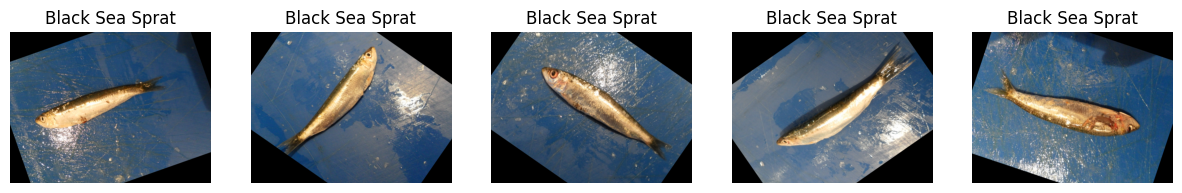

In [6]:
sample_class = 'Black Sea Sprat'  
sample_images = data[data['label'] == sample_class].sample(5)

plt.figure(figsize=(15, 8))
for i, row in enumerate(sample_images.iterrows()):
    img_path = row[1]['path']
    img = plt.imread(img_path)
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.title(sample_class)
    plt.axis('off')
plt.show()


### 5. Örnek Resimlerin Görselleştirilmesi

Bu bölümde, belirli bir sınıftan (örneğin, 'Black Sea Sprat') rastgele 5 örnek resim seçip görselleştiriyoruz. Öncelikle, bu sınıfa ait resimleri filtreliyoruz ve ardından matplotlib kütüphanesi ile görselleştiriyoruz. Her bir resim için bir alt grafik oluşturuyor ve resmi başlık olarak sınıf adını ekliyoruz. Bu işlem, veri setimizin içeriğini görsel olarak incelememize yardımcı olur.

In [7]:
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
train_generator = train_datagen.flow_from_directory(
    directory=fish_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    subset='training',
    class_mode='categorical'
)

validation_generator = train_datagen.flow_from_directory(
    directory=fish_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    subset='validation',
    class_mode='categorical'
)

num_classes = len(train_generator.class_indices)


Found 14400 images belonging to 9 classes.
Found 3600 images belonging to 9 classes.


### 6. Veri Üreticilerinin Hazırlanması

Bu kısımda, görüntü verilerimizi hazırlamak için ImageDataGenerator kullanıyoruz. rescale=1./255 ile görüntüleri normalize ediyoruz ve validation_split=0.2 ile verimizin %20'sini doğrulama seti olarak ayırıyoruz. flow_from_directory fonksiyonu, belirtilen dizinden resimleri yükler ve eğitim ile doğrulama setlerini oluşturur. Son olarak, num_classes ile toplam sınıf sayısını belirliyoruz.

In [8]:
# Model Oluşturma Fonksiyonu
def build_model(hp):
    model_ann = tf.keras.Sequential()
    model_ann.add(layers.InputLayer(input_shape=(img_height, img_width, 3)))
    model_ann.add(layers.Flatten())

    # Gizli katman sayısı ve nöron sayısı için hiperparametre ayarları
    for i in range(hp.Int('num_layers', 1, 3)):
        model_ann.add(layers.Dense(units=hp.Int('units_' + str(i), 32, 512, step=32), activation='relu'))
        model_ann.add(layers.BatchNormalization())
        model_ann.add(layers.Dropout(rate=hp.Float('dropout_rate', 0.2, 0.5, step=0.1)))

    model_ann.add(layers.Dense(num_classes, activation='softmax'))

    # Modeli derleme
    model_ann.compile(
        optimizer=optimizers.Adam(learning_rate=hp.Float('learning_rate', 1e-4, 1e-2, sampling='LOG')),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model_ann


### 7. Model Oluşturma Fonksiyonu

Bu kısımda, hiperparametre optimizasyonu için kullanılacak bir model oluşturma fonksiyonu tanımlıyoruz. Model, girdi katmanı, gizli katmanlar (isteğe bağlı olarak eklenebilir), normalizasyon katmanları ve dropout katmanları içerir. Son olarak, modelimiz categorical_crossentropy kaybı ve Adam optimizasyon algoritması ile derleniyor.

In [9]:
# Hiperparametre optimizasyonu için Tuner oluşturma
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    directory='hyperparam_tuning',
    project_name='fish_classification'
)

# Hiperparametre optimizasyonunu başlatma
tuner.search(train_generator, epochs=10, validation_data=validation_generator)


Trial 5 Complete [00h 23m 40s]
val_accuracy: 0.7602777481079102

Best val_accuracy So Far: 0.7602777481079102
Total elapsed time: 02h 22m 06s


### 8. Hiperparametre Optimizasyonu için Tuner Oluşturma

Bu bölümde, RandomSearch sınıfını kullanarak hiperparametre optimizasyonu için bir tuner oluşturuyoruz. build_model fonksiyonu, denemeleri optimize etmek için kullanılacaktır. Ardından, search metodu ile eğitim ve doğrulama verileri üzerinde hiperparametre optimizasyonunu başlatıyoruz.

In [10]:
# En iyi modeli alma
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

# En iyi modeli değerlendirme
loss_ann, accuracy_ann = best_model.evaluate(validation_generator)
print(f'Best ANN Model - Validation loss: {loss_ann}')
print(f'Best ANN Model - Validation accuracy: {accuracy_ann}')


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 49152)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 160)            │     7,864,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 160)            │           640 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 160)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,909,673 (30.17 MB)

 Trainable params: 7,908,841 (30.17 MB)

 Non-trainable params: 832 (3.25 KB)

225/225 ━━━━━━━━━━━━━━━━━━━━ 40s 176ms/step - accuracy: 0.7611 - loss: 0.6895
Best ANN Model - Validation loss: 0.7035093903541565
Best ANN Model - Validation accuracy: 0.7602777481079102


### 9.En İyi Modeli Alma ve Değerlendirme

Bu kısımda, tuner tarafından belirlenen en iyi modeli alıyoruz ve özetini görüntülüyoruz. Ardından, bu modeli doğrulama verisi üzerinde değerlendiriyoruz. Elde edilen kayıp ve doğruluk değerlerini yazdırıyoruz. Bu, modelimizin performansını değerlendirmek için önemlidir.

225/225 ━━━━━━━━━━━━━━━━━━━━ 40s 175ms/step


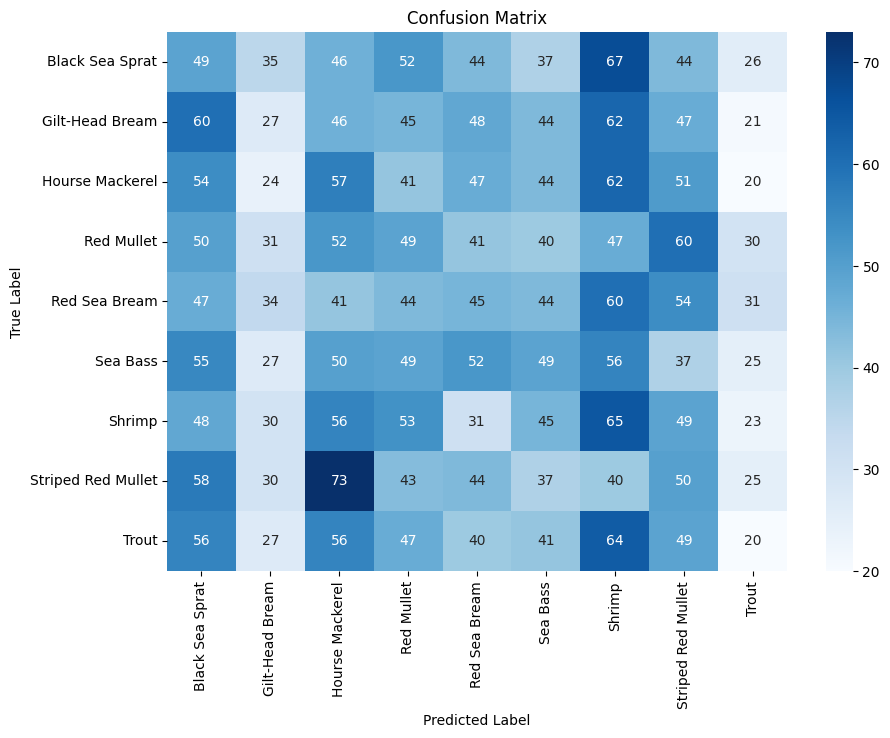

Classification Report:
                    precision    recall  f1-score   support

   Black Sea Sprat       0.10      0.12      0.11       400
   Gilt-Head Bream       0.10      0.07      0.08       400
   Hourse Mackerel       0.12      0.14      0.13       400
        Red Mullet       0.12      0.12      0.12       400
     Red Sea Bream       0.11      0.11      0.11       400
          Sea Bass       0.13      0.12      0.13       400
            Shrimp       0.12      0.16      0.14       400
Striped Red Mullet       0.11      0.12      0.12       400
             Trout       0.09      0.05      0.06       400

          accuracy                           0.11      3600
         macro avg       0.11      0.11      0.11      3600
      weighted avg       0.11      0.11      0.11      3600



In [11]:
# Doğrulama Verisi Üzerinde Tahminler
y_true = validation_generator.classes
y_pred = np.argmax(best_model.predict(validation_generator), axis=1)

# Karışıklık Matrisi ve Sınıflandırma Raporu
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=classes))

class_labels = list(train_generator.class_indices.keys())
plot_confusion_matrix(y_true, y_pred, class_labels)


### 10.Tahminler ve Karışıklık Matrisi

Bu bölümde, doğrulama verisi üzerindeki tahminleri alıyoruz. y_true gerçek etiketlerdir, y_pred ise modelin tahmin ettiği etiketlerdir. Ardından, bir karışıklık matrisini ve sınıflandırma raporunu oluşturmak için plot_confusion_matrix fonksiyonunu kullanıyoruz. Karışıklık matrisi, modelin hangi sınıfları doğru tahmin ettiğini ve hangi sınıflarda hata yaptığını gösterir.



Epoch 1/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 142s 154ms/step - accuracy: 0.6306 - loss: 1.0131 - val_accuracy: 0.7614 - val_loss: 0.7001
Epoch 2/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 136s 151ms/step - accuracy: 0.6412 - loss: 0.9700 - val_accuracy: 0.7219 - val_loss: 0.7757
Epoch 3/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 136s 151ms/step - accuracy: 0.6491 - loss: 0.9421 - val_accuracy: 0.7022 - val_loss: 0.7984
Epoch 4/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 137s 151ms/step - accuracy: 0.6625 - loss: 0.9205 - val_accuracy: 0.7808 - val_loss: 0.6717
Epoch 5/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 136s 151ms/step - accuracy: 0.6701 - loss: 0.9110 - val_accuracy: 0.7647 - val_loss: 0.7208
Epoch 6/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 137s 152ms/step - accuracy: 0.6771 - loss: 0.8785 - val_accuracy: 0.7425 - val_loss: 0.7371
Epoch 7/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 138s 153ms/step - accuracy: 0.6940 - loss: 0.8558 - val_accuracy: 0.7581 - val_loss: 0.7644
Epoch 8/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 135s 149ms/step - accuracy: 0.7022 -

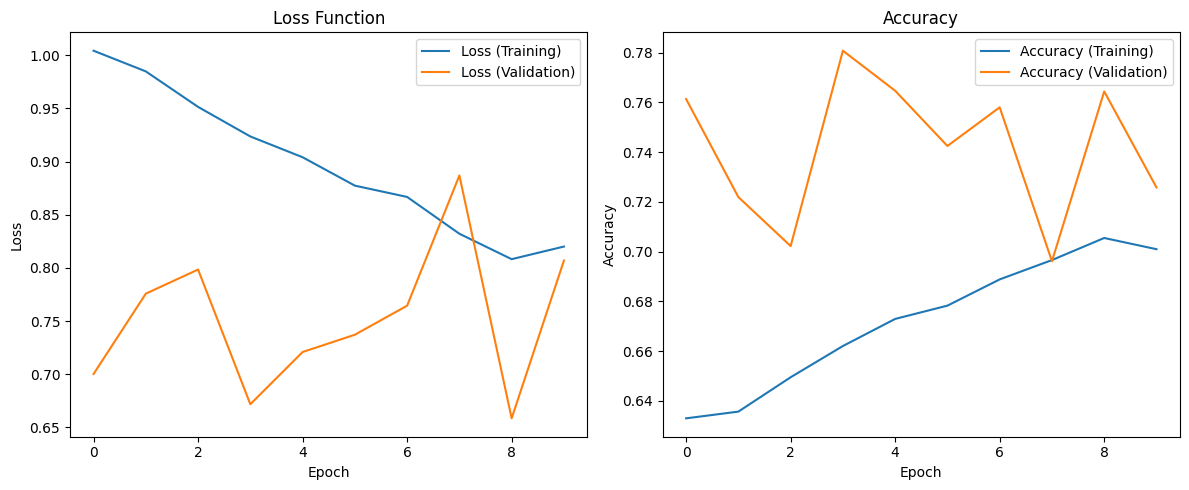

In [12]:
# Kayıp ve doğruluk fonksiyonlarını çizme
def plot_metrics(history):
    # Kayıp fonksiyonu grafiği
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Loss (Training)')
    plt.plot(history.history['val_loss'], label='Loss (Validation)')
    plt.title('Loss Function')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Doğruluk grafiği
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Accuracy (Training)')
    plt.plot(history.history['val_accuracy'], label='Accuracy (Validation)')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# En iyi modelin eğitimini yapma
history_best = best_model.fit(train_generator, epochs=10, validation_data=validation_generator)

# Kayıp ve doğruluk grafiğini çizme
plot_metrics(history_best)


### 11.Kayıp ve Doğruluk Fonksiyonlarını Çizme

Son bölümde, modelin eğitim sürecini görselleştirmek için plot_metrics fonksiyonu tanımlıyoruz. Bu fonksiyon, hem kayıp hem de doğruluk grafiğini çizer. Eğitim sürecinin ardından en iyi modelimizi 10 epoch boyunca eğitim verileri üzerinde eğitiyoruz ve ardından elde edilen kayıp ve doğruluk grafiklerini görüntülüyoruz. Bu grafikler, modelimizin nasıl performans gösterdiğini anlamamıza yardımcı olur.